In [1]:
# Import libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
from sklearn.linear_model import LinearRegression
import pandas as pd
import numpy as np

# Simple Baseline Models
# climatology --> predict (yt+h) as the mean daily precipitation for that calendar day over the training years
# persistence --> predict (yt+h = yt) or average over last few days
# linear regression --> flattened feature vector zt = vec(xt-T+1)


def create_history_windows(X, y, T=7, horizon=1):

    X_window = []
    y_window = []
    num_days = len(X)

    for t in range(T-1, num_days-horizon):
        X_window.append(X[t-T+1 : t+1])
        y_window.append(y[t + horizon])

    return np.array(X_window), np.array(y_window)

class ClimatologyModel:

    def __init__(self):
        self.day_mean = None

    def fit(self, y_train, dates_train):
        day_of_year = np.array([pd.to_datetime(d).timetuple().tm_yday for d in dates_train])
        unique_days = np.unique(day_of_year)
        self.day_mean = {day: np.mean(y_train[day_of_year == day]) for day in unique_days}

    def predict(self, dates_test):
        day_of_year = np.array([pd.to_datetime(d).timetuple().tm_yday for d in dates_test])
        return np.array([self.day_mean[day] for day in day_of_year])


class PersistenceModel:
    def __init__(self, window=7):
        self.window = window
        self.y_train = None

    def fit(self, y_train):
        self.y_train = y_train

    def predict(self, y_test_window, horizon=1):
        history = list(self.y_train)
        preds = []

        for i in range(len(y_test_window)):
            avg = np.mean(history[-self.window:])
            preds.append(avg)
            history.append(y_test_window[i])

        return np.array(preds)


class LinearRegressionModel:

    def __init__(self):
        self.model = LinearRegression()
        self.T = None
        self.d = None

    def fit(self, X_train, y_train):
        self.T = X_train.shape[1]
        self.d = X_train.shape[2]

        X_flat = X_train.reshape(len(X_train), self.T * self.d)
        self.model.fit(X_flat, y_train)

    def predict(self, X_test):
        X_flat = X_test.reshape(len(X_test), self.T * self.d)
        return self.model.predict(X_flat)

In [6]:
# # Uncomment this code if running in google colab and load data
# from google.colab import files
# uploaded = files.upload()
# csv = 'era5_1960to2020_17feats_standard.csv'


# Or load the csv from the local repository
# Comment this code out if running in google colab
import sys
from pathlib import Path
sys.path.append(str(Path("../").resolve()))
processed_folder = "../data"
data_path = f"{processed_folder}/era5_1960to2020_17feats_standard.csv"
csv = data_path

In [7]:
print("*"*60)
print("Loading ERA5 Data")
print("*"*60)

data = pd.read_csv(csv)

************************************************************
Loading ERA5 Data
************************************************************


In [8]:
data.head()

,time,10m_u_component_of_wind,10m_v_component_of_wind,2m_temperature,divergence,geopotential,mean_sea_level_pressure,relative_humidity,specific_humidity,temperature,total_cloud_cover,total_column_water_vapour,u_component_of_wind,v_component_of_wind,vertical_velocity,wind_speed,total_precipitation
0,01-01-1960,-5.273945,-1.630001,284.47314,6.746101e-07,79837.780,101558.33,0.393807,0.002249,246.70030,0.927847,25.958770,19.734486,6.541474,-0.067947,24.286242,18.164043
1,01-02-1960,-3.699429,0.139696,286.79053,-1.688271e-06,80214.805,101497.78,0.397636,0.002394,247.72574,0.953978,24.971188,21.852226,4.564419,-0.020838,24.671007,0.543005
2,01-03-1960,1.705438,-3.226488,286.29620,9.848103e-07,80392.766,101752.70,0.441990,0.002275,247.19296,0.708317,26.079035,26.410805,6.489832,0.018937,28.650595,15.890145
3,01-04-1960,-1.406776,-3.184707,281.74396,1.327395e-06,80548.125,102363.53,0.346748,0.001291,246.25536,0.752043,16.977570,21.157253,7.056201,-0.003446,23.580370,0.000035
4,01-05-1960,-3.580756,-1.209632,284.76740,6.520804e-07,80563.550,102142.63,0.401364,0.002202,246.91283,0.878167,27.715376,19.869293,10.268327,-0.044295,24.125340,0.474915


In [9]:
#reframing code to show the main columns: time, divergence, geopotential, relative_humidity, temp, u and v components of wind, vertical velocity, total_precip
data = data[['time', 'divergence', 'geopotential', 'relative_humidity', 'temperature', 'u_component_of_wind', 'v_component_of_wind', 'vertical_velocity', 'total_precipitation']]
data.head()

,time,divergence,geopotential,relative_humidity,temperature,u_component_of_wind,v_component_of_wind,vertical_velocity,total_precipitation
0,01-01-1960,6.746101e-07,79837.780,0.393807,246.70030,19.734486,6.541474,-0.067947,18.164043
1,01-02-1960,-1.688271e-06,80214.805,0.397636,247.72574,21.852226,4.564419,-0.020838,0.543005
2,01-03-1960,9.848103e-07,80392.766,0.441990,247.19296,26.410805,6.489832,0.018937,15.890145
3,01-04-1960,1.327395e-06,80548.125,0.346748,246.25536,21.157253,7.056201,-0.003446,0.000035
4,01-05-1960,6.520804e-07,80563.550,0.401364,246.91283,19.869293,10.268327,-0.044295,0.474915


In [10]:
# Convert time column to datetime
data['time'] = pd.to_datetime(data['time'])

# Sort by time (important for time series)
df = data.sort_values('time').reset_index(drop=True)

print(f"\nTime range: {df['time'].min()} to {df['time'].max()}")
print(f"Total timesteps: {len(df)}")



Time range: 1960-01-01 00:00:00 to 2020-12-31 00:00:00
Total timesteps: 22281


In [11]:
# Split by time ranges
df_filtered = df[(df['time'] >= '1960-01-01') & (df['time'] <= '2020-12-31')]
df_train = df_filtered[(df_filtered['time'] >= '1960-01-01') &
                       (df_filtered['time'] <= '2015-12-31')]
df_val = df_filtered[(df_filtered['time'] >= '2016-01-01') &
                     (df_filtered['time'] <= '2018-12-31')]
df_test = df_filtered[(df_filtered['time'] >= '2019-01-01') &
                      (df_filtered['time'] <= '2020-12-31')]

In [12]:
print(f"Training Duration: {df_train['time'].min()} - {df_train['time'].max()} ({len(df_train)} samples)")
print(f"Validation Duration: {df_val['time'].min()} - {df_val['time'].max()} ({len(df_val)} samples)")
print(f"Testing Duration: {df_test['time'].min()} - {df_test['time'].max()} ({len(df_test)} samples)")

Training Duration: 1960-01-01 00:00:00 - 2015-12-31 00:00:00 (20454 samples)
Validation Duration: 2016-01-01 00:00:00 - 2018-12-31 00:00:00 (1096 samples)
Testing Duration: 2019-01-01 00:00:00 - 2020-12-31 00:00:00 (731 samples)


## Preprocessing step complete in another notebook. Continuing with building baseline models.

In [13]:
from sklearn.preprocessing import StandardScaler

In [14]:
# LINEAR REGRESSION MODEL
feature_columns = [c for c in df_train.columns if c not in ['time', 'total_precipitation']]
X_train = df_train[feature_columns].values
X_val   = df_val[feature_columns].values
X_test  = df_test[feature_columns].values

y_train = df_train['total_precipitation'].values
y_val   = df_val['total_precipitation'].values
y_test  = df_test['total_precipitation'].values

In [15]:
scaler = StandardScaler()
X_train_ss = scaler.fit_transform(X_train)
X_val_ss = scaler.transform(X_val)
X_test_ss = scaler.transform(X_test)

In [16]:
#T=3

T = 3
h = 3
X_train_wdw, y_train_wdw = create_history_windows(X_train_ss, y_train, T=7, horizon=h)
X_val_wdw, y_val_wdw = create_history_windows(X_val_ss, y_val, T=7, horizon=h)
X_test_wdw, y_test_wdw = create_history_windows(X_test_ss, y_test, T=7, horizon=h)

print(f"Training window shape: {X_train_wdw.shape}")
print(f"Validation window shape: {X_val_wdw.shape}")
print(f"Testing window shape: {X_test_wdw.shape}")

Training window shape: (20445, 7, 7)
Validation window shape: (1087, 7, 7)
Testing window shape: (722, 7, 7)


In [17]:
#T=7
T = 7
h = 3
X_train_wdw, y_train_wdw = create_history_windows(X_train_ss, y_train, T=7, horizon=h)
X_val_wdw, y_val_wdw = create_history_windows(X_val_ss, y_val, T=7, horizon=h)
X_test_wdw, y_test_wdw = create_history_windows(X_test_ss, y_test, T=7, horizon=h)

print(f"Training window shape: {X_train_wdw.shape}")
print(f"Validation window shape: {X_val_wdw.shape}")
print(f"Testing window shape: {X_test_wdw.shape}")

Training window shape: (20445, 7, 7)
Validation window shape: (1087, 7, 7)
Testing window shape: (722, 7, 7)


In [25]:
# Train linear regression model
model = LinearRegressionModel()
model.fit(X_train_wdw, y_train_wdw)

y_pred = model.predict(X_test_wdw)

print("MAE:", mean_absolute_error(y_test_wdw, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test_wdw, y_pred)))

MAE: 4.762378702861934
RMSE: 7.910322587300012


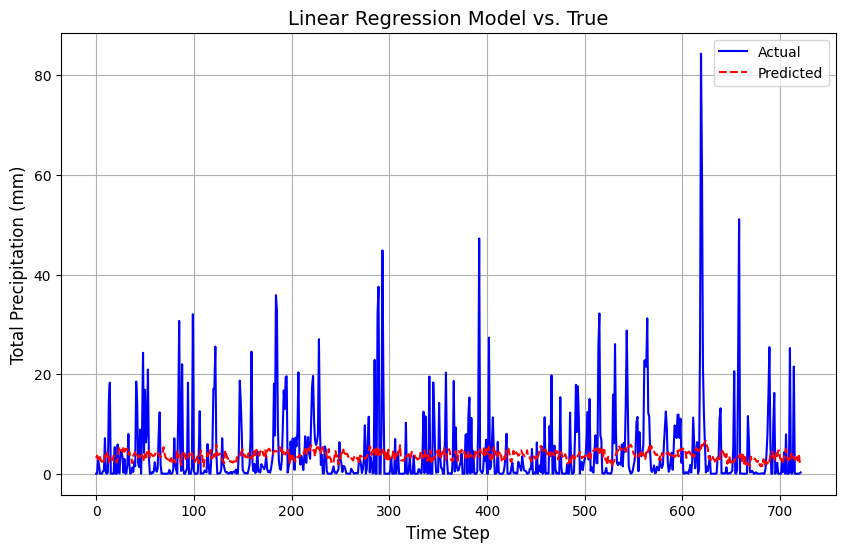

In [26]:
# Plot testing results pred vs. actual
plt.figure(figsize=(10, 6))
plt.plot(y_test_wdw, label='Actual', color='blue')
plt.plot(y_pred, label='Predicted', color='red', linestyle='--')
plt.title('Linear Regression Model vs. True', fontsize=14)
plt.xlabel('Time Step', fontsize=12)
plt.ylabel('Total Precipitation (mm)', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

In [27]:
# Train climatology model
offset = T-1+h
clim_model = ClimatologyModel()
clim_model.fit(y_train, df_train['time'])
clim_pred = clim_model.predict(df_test['time'].iloc[offset:offset+len(y_test_wdw)]) #slicing .


persist_wdw = 7
persist_pred_fixed = []
for i in range(len(X_test_wdw)):
    persist_end = T - 1 + h + i
    persist_start = max(0, persist_end - persist_wdw)
    # Getting the history from y_test
    if persist_end < len(y_test):
        recent_precip = y_test[persist_start:persist_end]
        persist_pred_fixed.append(np.mean(recent_precip))

persist_pred_fixed = np.array(persist_pred_fixed)

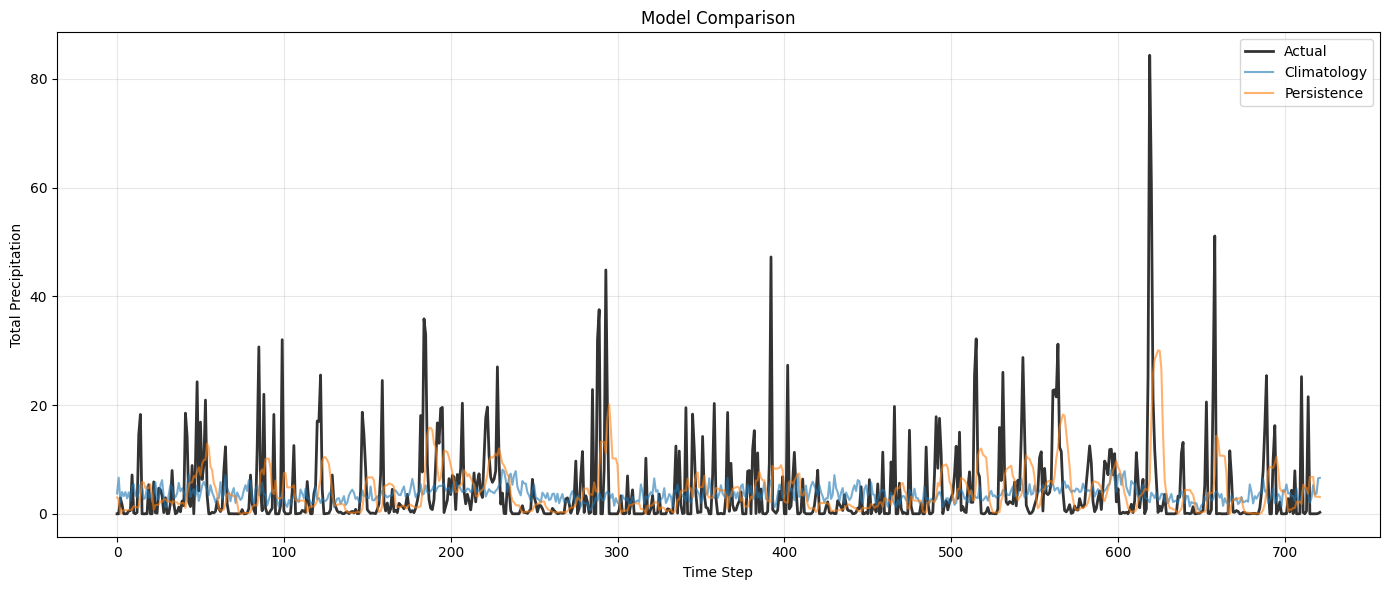

In [28]:
# Plot results pred vs. true
plt.figure(figsize=(14, 6))
plt.plot(y_test_wdw, label='Actual', alpha=0.8, linewidth=2, color='black')
plt.plot(clim_pred, label='Climatology', alpha=0.6, linewidth=1.5)
plt.plot(persist_pred_fixed, label='Persistence', alpha=0.6, linewidth=1.5)
plt.title('Model Comparison')
plt.xlabel('Time Step')
plt.ylabel('Total Precipitation')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [29]:
# Calculate RMSE and MAE error results
clim_mae = mean_absolute_error(y_test_wdw, clim_pred)
clim_rmse = np.sqrt(np.mean((clim_pred - y_test_wdw) ** 2))

persist_mae = mean_absolute_error(y_test_wdw, persist_pred_fixed)
persist_rmse = np.sqrt(np.mean((persist_pred_fixed - y_test_wdw) ** 2))

In [30]:
print("Persistence Model - MAE:", persist_mae, "RMSE:", persist_rmse)
print("Climatology Model - MAE:", clim_mae, "RMSE:", clim_rmse)

Persistence Model - MAE: 5.160327260923312 RMSE: 8.400338600777406
Climatology Model - MAE: 4.706815990757566 RMSE: 7.965157664577804


In [31]:
# Create Transformer model
class TransformerModel(Dataset):
    def __init__(self, X, y):
      self.X = torch.FloatTensor(X)
      self.y = torch.FloatTensor(y)

    def __len__ (self):
      return len(self.X)

    def __getitem__(self, index):
      return self.X[index], self.y[index]

batch = 32

train = TransformerModel(X_train_wdw, y_train_wdw)
val = TransformerModel(X_val_wdw, y_val_wdw)
test = TransformerModel(X_test_wdw, y_test_wdw)

train_load = DataLoader(train, batch_size=batch, shuffle=True)
val_load = DataLoader(val, batch_size=batch, shuffle=False)
test_load = DataLoader(test, batch_size=batch, shuffle=False)

## Initializing the Transformer Model


In [32]:
# Define parameters to use during training
# Update these to test different models
input_dim = X_train_wdw.shape[2]  # # features
model_dim = 64  # dimensions
num_heads = 4  # number of attention heads
num_layers = 2  # trans. layers
output_dim = 1  # want to predict total_precipitation

In [33]:
print("*"*40)
print("This it the TRANSFORMER ENCODER")
print("*"*40)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

class TransformerEncoderModel(nn.Module):
    def __init__(self, input_dim, model_dim, num_heads, num_layers, output_dim):
        """
        Args:
            input_dim: number of input features per time step
            model_dim: dimension in the model
            num_heads: number of attention heads
            num_layers: number of transformer encoder layers
            output_dim: number of output features
        """
        super(TransformerEncoderModel, self).__init__()

        #start of the encoder
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=model_dim, nhead=num_heads)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)

        #creating linear layer: Transformer output -> target dim
        self.fc = nn.Linear(model_dim, output_dim)

        # Transforming input_dim to model_dim
        self.input_embedding = nn.Linear(input_dim, model_dim)

    def forward(self, x):
        """
        Args:
            x: input tensor of shape (batch_size, seq_len, input_dim)
        """

        x = self.input_embedding(x) #initial shape
        x = x.permute(1,0,2)

        x = self.transformer_encoder(x) #predicting the last time step

        x = x[-1,:,:]

        x = self.fc(x)

        return x

****************************************
This it the TRANSFORMER ENCODER
****************************************
Using device: cpu


In [36]:
# Initialize Transformer model
model = TransformerEncoderModel(input_dim, model_dim, num_heads, num_layers, output_dim)
model = model.to(device)

In [37]:
print(f"Model params: {sum(p.numel() for p in model.parameters())}")

Model params: 844033


In [38]:
#Building loss and optimizer for Transformer Model

crit = nn.MSELoss()
opt = optim.Adam(model.parameters(), lr = 0.001)

#Training function for the Transformer
def train(model, data_loader, criterion, optimizer, device):
    model.train()
    train_loss = 0.0
    for X, y in data_loader:
      X = X.to(device)
      y = y.to(device).unsqueeze(1)

      optimizer.zero_grad()
      preds = model(X)
      loss = criterion(preds, y)
      loss.backward()
      optimizer.step()

      train_loss += loss.item() * len(X)

    return train_loss / len(data_loader.dataset)

def validate(model, data_loader, criterion, device):
    model.eval()
    val_loss = 0

    with torch.no_grad():
      for X, y in data_loader:
        X = X.to(device)
        y = y.to(device).unsqueeze(1)

        preds = model(X)
        loss = criterion(preds, y)
        val_loss += loss.item() * len(X)

    return val_loss / len(data_loader.dataset)

## Training the Transformer

In [39]:
# Train Transformer model
epochs = 50
train_losses = []
val_losses = []

for epoch in range(epochs):
    train_loss = train(model, train_load, crit, opt, device)
    val_loss = validate(model, val_load, crit, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

Epoch 10/50, Train Loss: 63.3713, Val Loss: 77.3795
Epoch 20/50, Train Loss: 63.0117, Val Loss: 77.6931
Epoch 30/50, Train Loss: 62.8316, Val Loss: 78.2375
Epoch 40/50, Train Loss: 62.7887, Val Loss: 78.9164
Epoch 50/50, Train Loss: 62.4453, Val Loss: 77.3107


In [47]:
# Helper function for evaluating training results on test data
def evaluate(model, loader, device):
    model.eval()
    predictions = []
    actual = []

    with torch.no_grad():
        for X,y in loader:
          X = X.to(device)
          pred = model(X)
          predictions.append(pred.cpu().numpy())
          actual.append(y.numpy())

    return np.concatenate(predictions).flatten(), np.concatenate(actual)

In [48]:
# Compute MAE and RMSE results
print("\nGetting predictions on test set...")
transformer_pred, transformer_actual = evaluate(model, test_load, device)

transformer_mae = mean_absolute_error(transformer_actual, transformer_pred)
transformer_rmse = np.sqrt(mean_squared_error(transformer_actual, transformer_pred))



Getting predictions on test set...


In [49]:
# Convert to dataframe for easy visualization
results_df = pd.DataFrame({
    'actual': transformer_actual,
    'predicted': transformer_pred
})

# Save results if needed
# results_df.to_csv('Downloads\\transformer_predictions.csv', index=False)

In [50]:
# Download results from google colab
# from google.colab import files
# files.download('transformer_predictions.csv')

In [51]:
# Preview results
results_df

,actual,predicted
0,0.000000,2.363032
1,0.000035,5.450954
2,2.903764,1.945517
3,1.682915,1.898344
4,0.000248,2.001196
...,...,...
717,0.000000,3.669235
718,0.000000,3.609170
719,0.002043,2.953027
720,0.071317,2.664374


## Evaluating on the testing data


In [52]:
#METRICS
transformer_mae = mean_absolute_error(transformer_actual, transformer_pred)
transformer_rmse = np.sqrt(mean_squared_error(transformer_actual, transformer_pred))

print("MODEL PERFORMANCE")

print(f"Persistence - MAE: {persist_mae:.3f}, RMSE:{persist_rmse:.3f}")
print(f"Climatology - MAE: {clim_mae:.3f}, RMSE:{clim_rmse:.3f}")
print(f"Transformer - MAE: {transformer_mae:.3f}, RMSE:{transformer_rmse:.3f}")


MODEL PERFORMANCE
Persistence - MAE: 5.160, RMSE:8.400
Climatology - MAE: 4.707, RMSE:7.965
Transformer - MAE: 4.935, RMSE:7.869


In [53]:
#extreme precipitation RMSE
th = 95
extreme_th = np.percentile(transformer_actual, th)

print(f"Threshold for extreme precipitation: {extreme_th} mm")

transformer_extreme = transformer_actual > extreme_th
events_count = np.sum(transformer_extreme)

print(f"Number of extreme events: {events_count} out of {len(transformer_actual)} samples")

extreme_actual = transformer_actual[transformer_extreme]
extreme_pred = transformer_pred[transformer_extreme]

extreme_mae = mean_absolute_error(extreme_actual, extreme_pred)
extreme_rmse = np.sqrt(mean_squared_error(extreme_actual, extreme_pred))

non_extreme_indices = ~transformer_extreme
non_extreme_actual = transformer_actual[non_extreme_indices]
non_extreme_pred = transformer_pred[non_extreme_indices]

non_extreme_mae = mean_absolute_error(non_extreme_actual, non_extreme_pred)
non_extreme_rmse = np.sqrt(mean_squared_error(non_extreme_actual, non_extreme_pred))

# Print comparison
print("\n" + "="*70)
print("TRANSFORMER PERFORMANCE: OVERALL vs EXTREME EVENTS")
print("="*70)
print(f"Overall Performance      - MAE: {transformer_mae:.3f}, RMSE: {transformer_rmse:.3f}")
print(f"Extreme Events - MAE: {extreme_mae:.3f}, RMSE: {extreme_rmse:.3f}")
print(f"Non-Extreme Events       - MAE: {non_extreme_mae:.3f}, RMSE: {non_extreme_rmse:.3f}")
print("="*70)

# Additional extreme event metrics
mean_actual_extreme = np.mean(extreme_actual)
mean_pred_extreme = np.mean(extreme_pred)
print(f"\nExtreme Events - Mean Actual: {mean_actual_extreme:.3f}, Mean Predicted: {mean_pred_extreme:.3f}")
print(f"Underprediction bias: {mean_actual_extreme - mean_pred_extreme:.3f} mm")

Threshold for extreme precipitation: 19.735929489135742 mm
Number of extreme events: 37 out of 722 samples

TRANSFORMER PERFORMANCE: OVERALL vs EXTREME EVENTS
Overall Performance      - MAE: 4.935, RMSE: 7.869
Extreme Events - MAE: 25.650, RMSE: 28.663
Non-Extreme Events       - MAE: 3.816, RMSE: 4.570

Extreme Events - Mean Actual: 30.184, Mean Predicted: 4.534
Underprediction bias: 25.650 mm


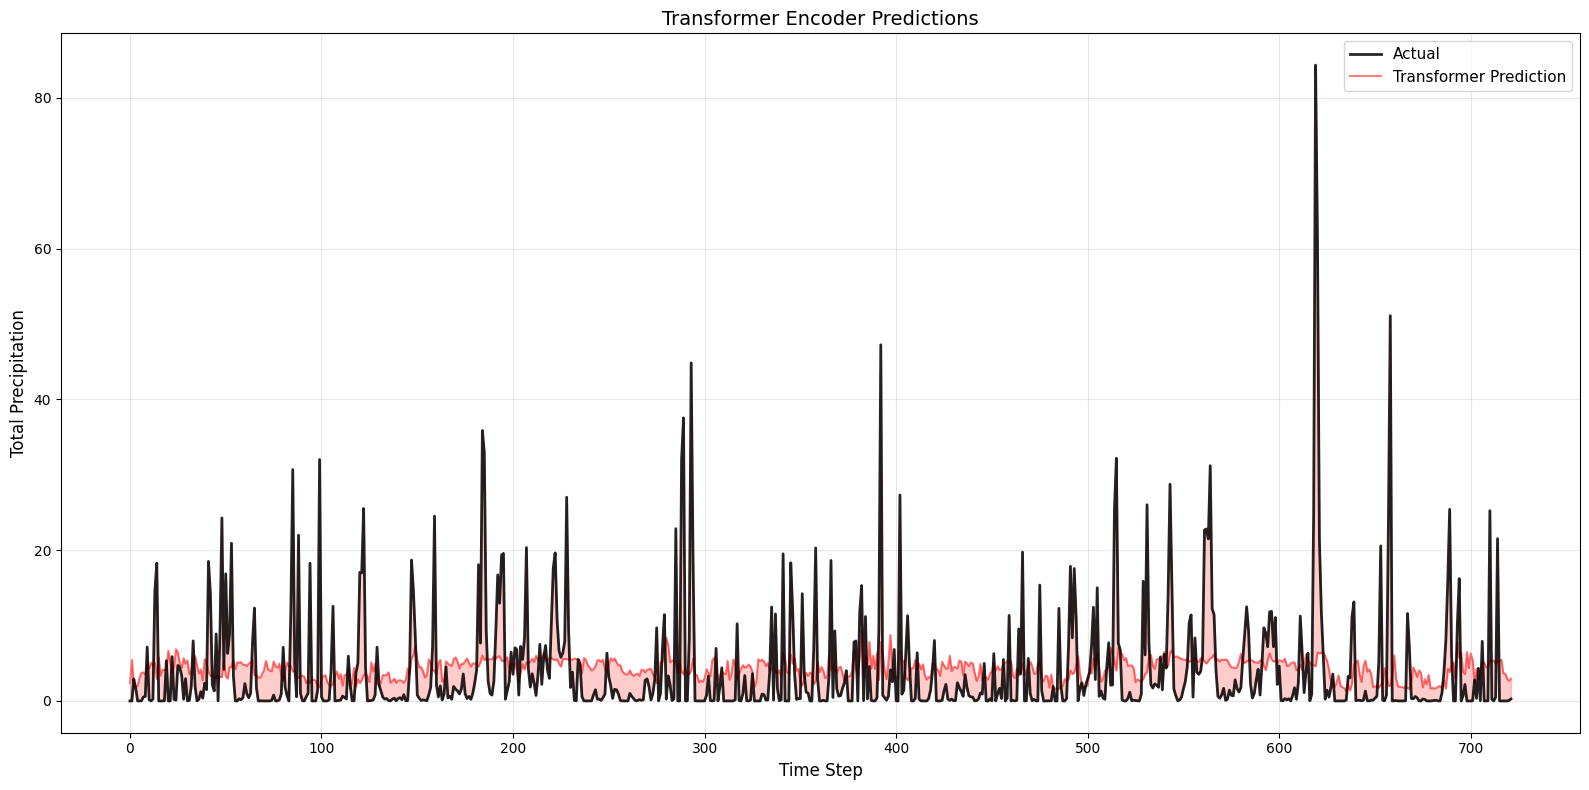

In [54]:
# Plot transformer predictions on true test vals
transformer_data = min(750, len(transformer_actual))

plt.figure(figsize=(16, 8))
plt.plot(transformer_actual[:transformer_data], label='Actual', alpha=0.85, linewidth=2, color='black', zorder=2)
plt.plot(transformer_pred[:transformer_data], label='Transformer Prediction', alpha=0.5, linewidth=1.5, color='red', zorder=1)

#signifying errors
plt.fill_between(range(transformer_data), transformer_actual[:transformer_data], transformer_pred[:transformer_data],
                 alpha=0.2, color='red')
plt.title(f'Transformer Encoder Predictions',
          fontsize=14)
plt.xlabel('Time Step', fontsize=12)
plt.ylabel('Total Precipitation', fontsize=12)
plt.legend(loc='best', fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

#What is causing this error?
- The black line represents the test data which spans from 2019-2020. This is the real accumulated precipitation during both years. The red line shows the transformer model's predictions at t+3 days, with it predicting around 5mm. However, it struggles to predict extreme events that are shown via the large spikes.

# Find predicted values of the transformer after running the training. Array of all days

In [56]:
lr_model = LinearRegressionModel()
lr_model.fit(X_train_wdw, y_train_wdw)
lr_pred = lr_model.predict(X_test_wdw)

transformer_model = TransformerEncoderModel(input_dim, model_dim, num_heads, num_layers, output_dim)
transformer_model = transformer_model.to(device)

transformer_pred, transformer_actual = evaluate(transformer_model, test_load, device)

C:\Users\natal\anaconda3\envs\dl\Lib\site-packages\torch\nn\modules\transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [57]:
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0

    for X_batch, y_batch in loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device).unsqueeze(1)  # shape (batch, 1)

        optimizer.zero_grad()
        predictions = model(X_batch)
        loss = criterion(predictions, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * len(X_batch)

    return total_loss / len(loader.dataset)

In [59]:
# num_epochs = 50

# model = TransformerEncoderModel(input_dim, model_dim, num_heads, num_layers, output_dim)
# model = model.to(device)

# criterion = nn.MSELoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)

# for epoch in range(num_epochs):
#     train_loss = train_epoch(model, train_load, criterion, optimizer, device)
#     val_loss = validate(model, val_load, criterion, device)